In [1]:
from pathlib import Path
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import normalize

pd.options.display.max_columns = None
#pd.options.display.max_rows = None
pd.options.display.max_colwidth = None
pd.options.display.precision = 20

In [2]:
a, i, r = (pd.read_csv("student_movie_attributes.csv"),
           pd.read_csv("student_movie_intent.csv"),
           pd.read_csv("student_movie_ratings.csv"))
a, i, r = (a.drop(['etl_run_guid', 'intent_score', 'survey_date', 'content_type', 'movie_name',
                   'household_size', 'gender_name', 'age_group_bracket', 'ethnicity_name',
                   'education_level', 'income_bracket'], axis=1),
           i.drop(['etl_run_guid'], axis=1),
           r.drop(['etl_run_guid', 'networks', 'content_type'], axis=1))
a, i, r = (a.sort_values(by=['respondent_id', 'movie_id']),
           i.sort_values(by=['respondent_id', 'movie_id']),
           r.sort_values(by=['respondent_id', 'movie_id']))
ir = r.merge(i, how='outer', on=['respondent_id', 'movie_id'])
air = ir.merge(a, how='outer', on=['respondent_id', 'movie_id'])
air = air.dropna()

# Sum the Attribute Score for Movies

genre = air[['intelligent', 'real', 'fun', 'touching', 'relatable', 'sad', 'romantic', 'informative', 'mean',
'fake', 'glamorous', 'original', 'predictable', 'fresh', 'mindless', 'unrelatable', 'funny',
'imaginative', 'wholesome', 'inspiring', 'shallow', 'edgy', 'fastpaced', 'disturbing', 'dramatic',
'outrageous', 'exciting', 'calming', 'slow', 'unoriginal', 'uplifting', 'sexy',
'deep', 'suspenseful', 'thrilling', 'scary', 'movie_name']].groupby('movie_name').sum()

genre = genre.apply(lambda x: x.astype('float64'))
genre

,intelligent,real,fun,touching,relatable,sad,romantic,informative,mean,fake,glamorous,original,predictable,fresh,mindless,unrelatable,funny,imaginative,wholesome,inspiring,shallow,edgy,fastpaced,disturbing,dramatic,outrageous,exciting,calming,slow,unoriginal,uplifting,sexy,deep,suspenseful,thrilling,scary
movie_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10 Cloverfield Lane,12.0,3.0,3.0,3.0,2.0,3.0,1.0,3.0,2.0,4.0,1.0,26.0,9.0,5.0,4.0,3.0,1.0,17.0,1.0,1.0,0.0,9.0,9.0,22.0,36.0,8.0,18.0,0.0,13.0,1.0,0.0,1.0,10.0,57.0,51.0,30.0
"10,000 BC",14.0,7.0,10.0,9.0,1.0,6.0,6.0,10.0,1.0,7.0,1.0,26.0,3.0,5.0,3.0,7.0,4.0,21.0,6.0,3.0,1.0,6.0,6.0,4.0,37.0,4.0,24.0,0.0,9.0,3.0,2.0,2.0,12.0,28.0,22.0,6.0
12 Strong,19.0,32.0,3.0,18.0,9.0,18.0,2.0,25.0,3.0,2.0,3.0,29.0,2.0,5.0,2.0,2.0,4.0,10.0,3.0,30.0,0.0,10.0,22.0,1.0,45.0,1.0,46.0,1.0,1.0,1.0,8.0,0.0,14.0,41.0,40.0,3.0
127 Hours,11.0,37.0,1.0,17.0,3.0,27.0,0.0,15.0,2.0,2.0,0.0,38.0,7.0,3.0,1.0,6.0,1.0,8.0,5.0,26.0,1.0,12.0,9.0,26.0,46.0,9.0,26.0,4.0,8.0,3.0,11.0,1.0,16.0,53.0,33.0,28.0
13 Going on 30,5.0,5.0,39.0,20.0,21.0,1.0,41.0,3.0,1.0,6.0,9.0,19.0,16.0,8.0,5.0,3.0,65.0,15.0,20.0,6.0,5.0,6.0,1.0,0.0,10.0,7.0,14.0,6.0,1.0,3.0,14.0,11.0,0.0,2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zoolander,1.0,0.0,33.0,0.0,5.0,1.0,4.0,1.0,1.0,11.0,6.0,18.0,3.0,6.0,27.0,3.0,64.0,11.0,2.0,5.0,9.0,12.0,8.0,2.0,10.0,18.0,14.0,1.0,4.0,0.0,2.0,3.0,1.0,1.0,3.0,1.0
Zootopia,15.0,3.0,38.0,14.0,9.0,6.0,4.0,3.0,0.0,3.0,4.0,23.0,7.0,15.0,6.0,3.0,61.0,30.0,27.0,15.0,2.0,3.0,11.0,0.0,13.0,0.0,21.0,1.0,1.0,1.0,15.0,2.0,6.0,4.0,11.0,1.0
mother!,18.0,6.0,1.0,6.0,1.0,15.0,1.0,5.0,2.0,8.0,0.0,32.0,5.0,7.0,8.0,13.0,1.0,22.0,2.0,5.0,1.0,12.0,10.0,46.0,34.0,7.0,11.0,1.0,16.0,2.0,1.0,0.0,22.0,46.0,30.0,33.0


# CLUSTER ANALYSIS
### Change number of clusters on the fifth line (n_clusters = ???)

,intelligent,real,fun,touching,relatable,sad,romantic,informative,mean,fake,glamorous,original,predictable,fresh,mindless,unrelatable,funny,imaginative,wholesome,inspiring,shallow,edgy,fastpaced,disturbing,dramatic,outrageous,exciting,calming,slow,unoriginal,uplifting,sexy,deep,suspenseful,thrilling,scary,cluster
0,0.055,0.483,0.309,1.605,0.941,0.630,1.189,-0.044,-0.412,-0.288,0.232,0.404,0.513,0.647,-0.249,-0.240,0.247,0.155,1.552,1.148,-0.292,-0.702,-0.544,-0.559,-4.979e-04,-0.557,-0.208,1.408,0.281,-0.068,1.652,-0.021,0.367,-0.628,-0.667,-0.432,Cluster 0
1,0.193,-0.418,-0.202,-0.562,-0.597,-0.182,-0.382,-0.303,-0.019,0.342,-0.239,0.133,0.110,-0.275,-0.178,0.088,-0.511,0.424,-0.559,-0.446,-0.025,0.784,0.863,0.568,5.489e-01,0.149,0.755,-0.547,-0.055,0.167,-0.533,-0.043,0.013,1.139,1.210,0.755,Cluster 1
2,-0.605,-0.384,-0.729,-0.506,-0.473,-0.401,-0.306,-0.246,-0.170,-0.543,-0.220,-0.929,-0.656,-0.707,-0.504,-0.410,-0.555,-0.750,-0.476,-0.482,-0.460,-0.571,-0.582,-0.330,-8.184e-01,-0.556,-0.868,-0.301,-0.396,-0.404,-0.522,-0.229,-0.485,-0.638,-0.652,-0.291,Cluster 2
3,1.032,1.300,-0.478,0.503,0.574,0.840,0.022,1.419,0.992,-0.241,0.502,0.591,-0.095,0.319,-0.190,0.531,-0.438,-0.061,-0.045,0.787,-0.096,0.440,-0.110,0.593,8.844e-01,-0.130,0.101,0.260,0.781,0.098,-0.001,0.265,1.117,0.326,0.074,0.008,Cluster 3
4,-0.512,-0.452,1.132,-0.287,0.131,-0.462,-0.034,-0.479,-0.317,0.493,-0.108,-0.023,0.236,0.341,1.052,0.028,1.383,0.118,0.138,-0.399,0.786,-0.322,-0.106,-0.484,-6.034e-01,0.846,-0.082,-0.196,-0.360,0.147,0.060,0.059,-0.673,-0.645,-0.508,-0.394,Cluster 4
5,2.482,1.206,4.307,1.679,1.793,1.077,0.790,0.940,0.669,2.832,2.458,4.682,2.921,3.486,2.920,2.104,3.205,4.092,2.167,2.275,2.159,3.063,3.759,1.311,3.569e+00,3.206,4.916,1.246,1.636,2.153,1.997,1.673,1.536,2.625,3.144,1.444,Cluster 5


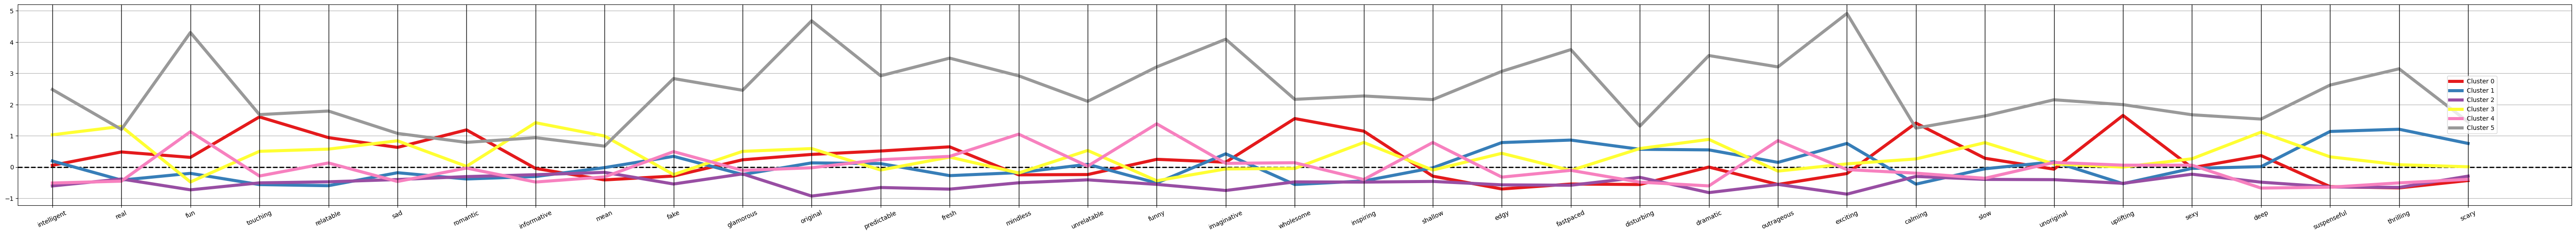

In [3]:
pd.options.display.max_columns = None

# Normalized distance
genre_norm = genre.apply(preprocessing.scale, axis=0)

# Cluster membership, CHANGE NUMBER OF CLUSTERS HERE
kmeans = KMeans(n_clusters=6, random_state=0).fit(genre_norm)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=genre_norm.columns)
pd.set_option('precision', 3)

centroids['cluster'] = ['Cluster {}'.format(i) for i in centroids.index]

fig = plt.figure(figsize=(20,6), dpi=100)
plt.xticks(rotation=25)
fig.subplots_adjust(right=3)
plt.axhline(y=0, color='black', linewidth=2, linestyle='dashed')
ax = parallel_coordinates(centroids, class_column='cluster', colormap='Set1', linewidth=5)
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))
plt.xlim(-0.5,36.5)
centroids

# 6 CLUSTERS NAMED + LIST OF CLUSTERED ATTRIBUTES

In [4]:
centroids = centroids.drop(['cluster'], axis=1)
centroids_transposed = centroids.T
centroids_transposed.columns = centroids_transposed.columns.astype(str)

# CREATES A LIST OF A RANGE OF THE NUMBER OF CLUSTERS, THEN COVERTED DATATYPES INTO STRINGS
s = []
for r in range(len(centroids)):
    s.append(str(r))

# MANUALLY NAMING CLUSTERS IN ORDER OF THEIR CLUSTER NUMBER
names = ["Romantic Drama","Action Thriller","???","Historical","Comedy","Fantasy/SciFi","Horror"]

# PRINT TOP 10 ATTRIBUTES THAT ARE OVER 0.7 FOR EACH CLUSTER
for a in s:
    print(names[int(a)])
    indv = centroids_transposed.sort_values(by=[a], ascending = False)
    indv = indv.loc[indv[a] > 0.7]
    print(indv[a].head(10))
    print('')

Romantic Drama
uplifting    1.652
touching     1.605
wholesome    1.552
calming      1.408
romantic     1.189
inspiring    1.148
relatable    0.941
Name: 0, dtype: float64

Action Thriller
thrilling      1.210
suspenseful    1.139
fastpaced      0.863
edgy           0.784
exciting       0.755
scary          0.755
Name: 1, dtype: float64

???
Series([], Name: 2, dtype: float64)

Historical
informative    1.419
real           1.300
deep           1.117
intelligent    1.032
mean           0.992
dramatic       0.884
sad            0.840
inspiring      0.787
slow           0.781
Name: 3, dtype: float64

Comedy
funny         1.383
fun           1.132
mindless      1.052
outrageous    0.846
shallow       0.786
Name: 4, dtype: float64

Fantasy/SciFi
exciting       4.916
original       4.682
fun            4.307
imaginative    4.092
fastpaced      3.759
dramatic       3.569
fresh          3.486
outrageous     3.206
funny          3.205
thrilling      3.144
Name: 5, dtype: float64



In [5]:
memb = pd.Series(kmeans.labels_, index=genre_norm.index)
for key, item in memb.groupby(memb):
    print(key, ': ', ''.join(str(item.index)))

0 :  Index(['16 Wishes', '17 Again', '50 First Dates', '50/50',
       'A Beautiful Day in the Neighborhood', 'A Brush with Love',
       'A Christmas Arrangement', 'A Christmas Prince: The Royal Wedding',
       'A Christmas Story', 'A Christmas for the Books',
       ...
       'Where the Wild Things Are', 'While You Were Sleeping', 'Wind [Short]',
       'Winnie the Pooh', 'Winter Castle', 'Winter Love Story',
       'Won't You Be My Neighbor?', 'Yesterday', 'You've Got Mail',
       'Yours, Mine & Ours'],
      dtype='object', name='movie_name', length=451)
1 :  Index(['10 Cloverfield Lane', '10,000 BC', '1408', '16 Blocks',
       '2 Fast 2 Furious', '2012', '3 Days to Kill', '300',
       '300: Rise of an Empire', '3:10 to Yuma',
       ...
       'X-Men: Apocalypse', 'X-Men: Days of Future Past', 'X-Men: First Class',
       'X-Men: The Last Stand', 'X2', 'You Only Live Twice', 'Zombie Night',
       'mother!', 'xXx', 'xXx: Return of Xander Cage'],
      dtype='object', name='mo

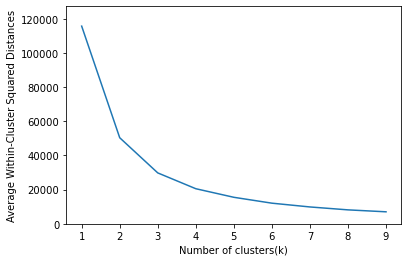

In [6]:
inertia = []
for n_clusters in range(1, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(genre_norm)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(1, 10), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()